In [44]:
#Importing the requirements
#libraries for data manipulation
import pandas as pd 
import numpy as np 
from collections import defaultdict,Counter

#libraries for data visualization
import seaborn  as sns
import matplotlib.pyplot as plt

#Downloading the words english model of spacy
import spacy
!python -m spacy download en_core_web_md

#Other libraries to deal with text normalization
from string import punctuation
from unidecode import unidecode

In [2]:
data = pd.read_csv('comments-trump.csv')

In [3]:
""""The data Contains 5857 comments without tags and 5955 comments with any attachment"""
data.isnull().sum()

message                       0
tags                       5857
created_time                  0
comment_attachment_type    5955
comment_likes                 0
dtype: int64

In [4]:
def most_commons(data,column,n_top):
    data = data[data[column].notnull()]
    values = data[column].tolist()
    top_values = list(dict(Counter(values).most_common(n_top)).keys())
    top_values = [value for value in top_values if value != 'nan']

    n_values = dict(Counter(values).most_common(n_top)).values()
    n_values = list(n_values)
    return top_values, n_values 

In [5]:
"""most 10 common tags"""
tag_vals, tag_freq = most_commons(data,'tags',10)

"""most 10 commennt attachment type"""
at_vals, at_freq = most_commons(data,'comment_attachment_type',10)

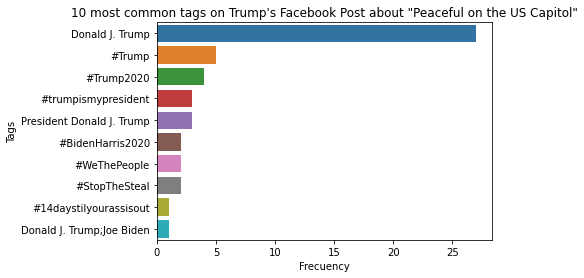

In [6]:
sns.barplot(x=tag_freq,y=tag_vals)
plt.title('10 most common tags on Trump\'s Facebook Post about "Peaceful on the US Capitol"')
plt.xlabel('Frecuency')
plt.ylabel('Tags')
plt.show()

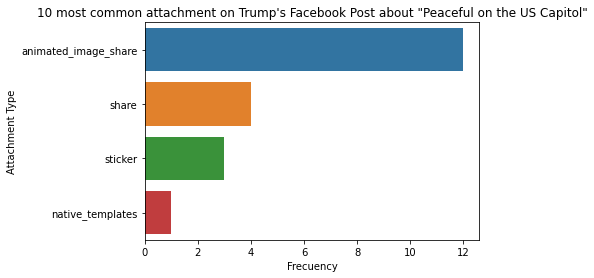

In [7]:
sns.barplot(x=at_freq,y=at_vals)
plt.title('10 most common attachment on Trump\'s Facebook Post about "Peaceful on the US Capitol"')
plt.xlabel('Frecuency')
plt.ylabel('Attachment Type')
plt.show()

In [8]:
"""displaying the most liked comment"""
most_liked_comment = data[data['comment_likes'].isin([data['comment_likes'].max()])]['message'].values
str(most_liked_comment)

"['You are the worst President in the history of America Mr Donald J. Trump ......   You are proving to be a worse dictator than the dictators from elsewhere around the World that America has been sanctioning!!!  But protests or not, on January 21st this month , you will be Ex President and Joe Biden will be the President of the United States of America!!!! Period!!!']"

-------------------------------------------NATURAL LANGUAGE PROCESSING SECTION!--------------------------------------------

In [9]:
"""Loading the  NLP model on spacy"""
nlp = spacy.load('en_core_web_md')

In [10]:
def normalize_comments(data):
    clean_comments = []
    #StopWords defined by Spacy model   +  Stopwords defined by me 
    stopwords = list(nlp.Defaults.stop_words)

    
    comments = data['message'].str.lower().tolist()
    for comment in comments:
        token_words = comment.split()

        clean_comments.append(" ".join(unidecode(word).lower() for word in token_words if word not in stopwords and word not in punctuation))

    data['clean_message'] = clean_comments
    data['clean_message'] = data['clean_message'].str.replace(r"[^\w]"," ")


    return data[['message','clean_message','tags','created_time','comment_attachment_type','comment_likes']]

In [11]:
"""Normalize the text of comments column"""
clean_data = normalize_comments(data)

In [12]:
clean_data.head()

,message,clean_message,tags,created_time,comment_attachment_type,comment_likes
0,The American people are tired of not being lis...,american people tired listen silent majority a...,NaN,2021-01-06T20:15:51+0000,NaN,8701.0
1,If you believe in the safety of your people th...,believe safety people step away quietly,NaN,2021-01-06T23:43:08+0000,NaN,8065.0
2,YOU GUYS LOST. GET OVER IT. 🙄 BYE 👋🏽,guys lost it bye,NaN,2021-01-06T20:15:42+0000,NaN,7327.0
3,I support President Trump.,support president trump,NaN,2021-01-06T20:32:48+0000,sticker,5848.0
4,It's too late Mr. President. The American peop...,it s late mr president american people fed g...,NaN,2021-01-06T20:16:57+0000,NaN,5433.0


In [13]:
def frecuency_words(data):
    total_words = []
    results = defaultdict(list)

    messages = data['clean_message'].unique().tolist()

    for message in messages:
        message = message.split()
        for m in message:
            if len(m)>1:
                total_words.append(m)
            else:
                pass
        
    words = Counter(total_words)
    values = list(words.values())
    words = list(words.keys())
    results['word'] = words
    results['frequency'] = values
   
    df = pd.DataFrame(results)

    return df

In [14]:
data_words = frecuency_words(data).sort_values(['frequency'],ascending=False)

In [15]:
data_words.head(20)

,word,frequency
1,people,2462
19,trump,2116
18,president,2105
109,country,1281
15,it,1229
86,you,1078
196,supporters,781
95,god,681
87,election,678
139,peaceful,666


In [19]:
def find_message_by_word(data,words):
    messages = data['message'].str.lower().tolist()
    comments = list()
    
    for message in messages:
        if any(unidecode(word) in message for word in words):
            comments.append(message)
             
    return comments


def find_adjs_by_comment(comments,pattern):
    words = []
    for comment in comments:
        doc = nlp(comment)
        for i in range(0,len(doc)):
            if any(word in doc[i].text for word in pattern):
                try:
                    for x in range(i-10,len(doc)):
                        if doc[x].pos_ == "ADJ":
                            words.append(doc[x].text)
                except:
                    for x in range(i,len(doc)):
                        if doc[x].pos_ == "ADJ":
                            words.append(doc[x].text)

    df = pd.DataFrame({'words':list(Counter(words).keys()),'freq':list(Counter(words).values())}).sort_values(['freq'],ascending=False)

    with open('adjectives.txt','r') as file:
        adjs = file.readlines()

    filters = [adj.replace("\n","") for adj in adjs]
    top_adjs = df[df.words.isin(filters)].reset_index(drop=True)

    return top_adjs

In [22]:
comments = find_message_by_word(data,'donald trump')
donald_trump_qualyfing_adjectives = find_adjs_by_comment(comments,['trump'])

In [26]:
donald_trump_qualyfing_adjectives.head(10)

,words,freq
0,sad,76
1,violent,75
2,strong,49
3,new,34
4,fair,29
5,big,25
6,long,23
7,amazing,22
8,little,18
9,beautiful,17


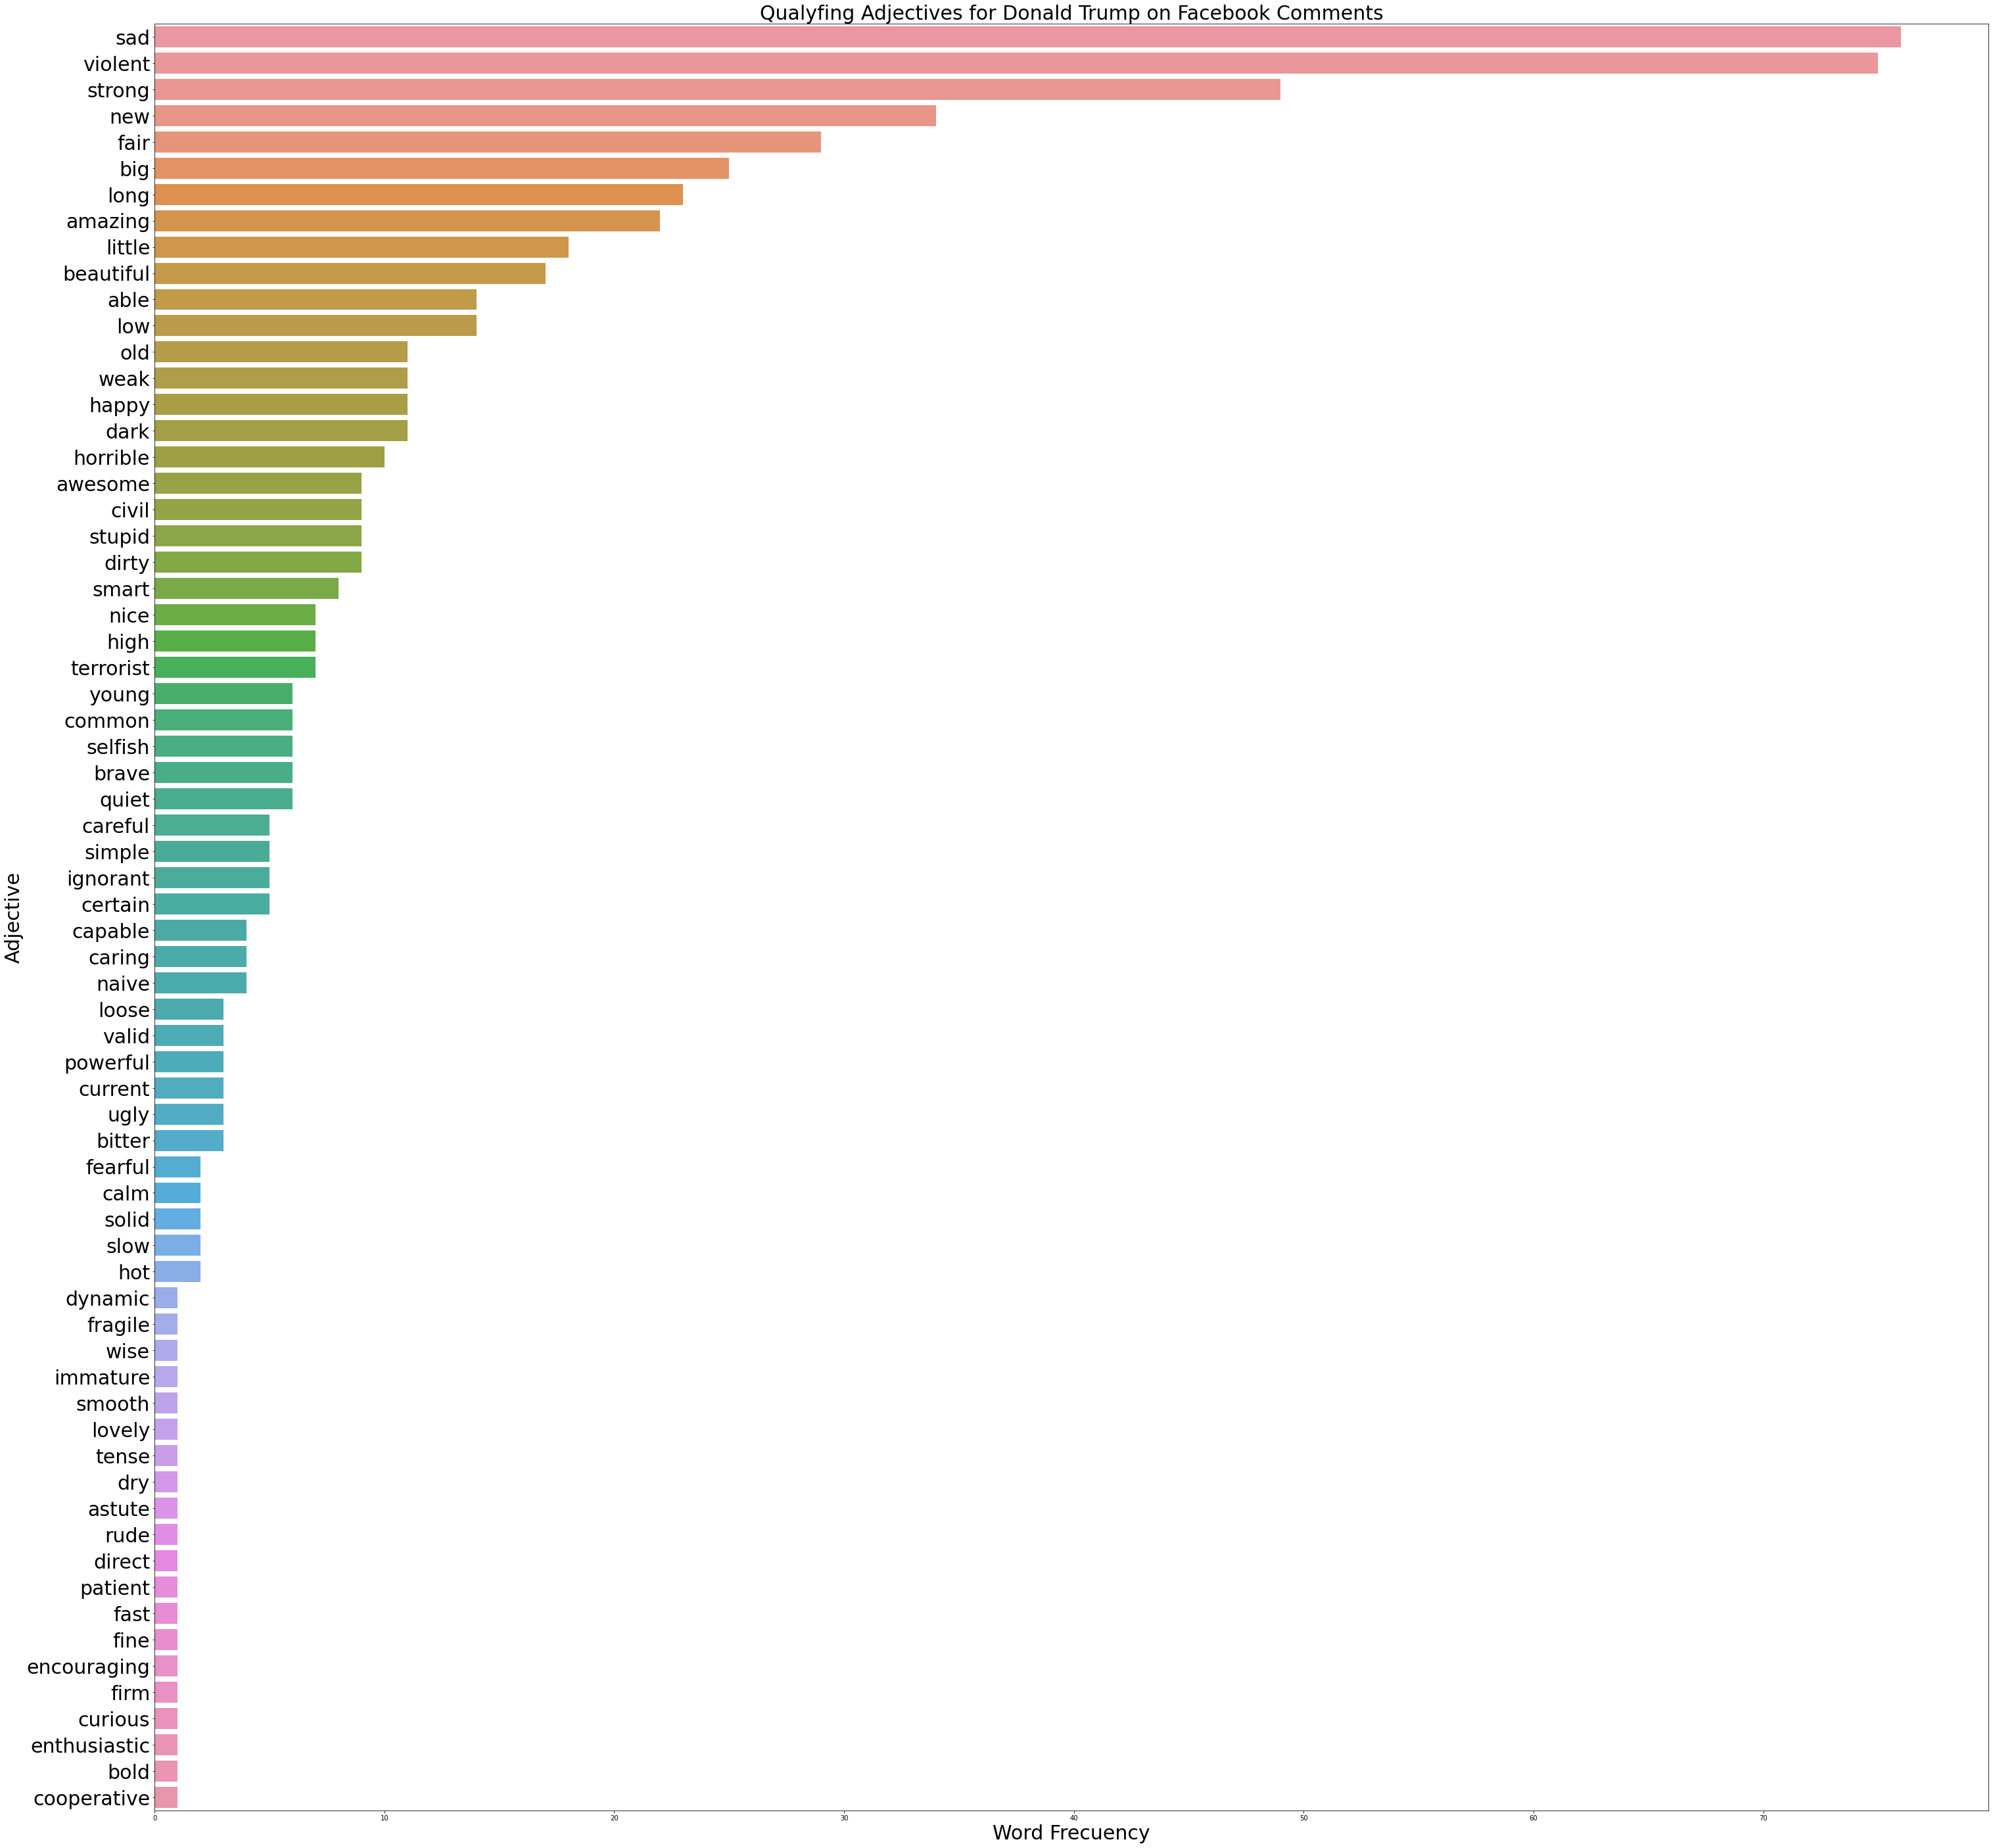

In [38]:
plt.figure(figsize=(50,50))
sns.barplot(x='freq',y='words',data=donald_trump_qualyfing_adjectives)
plt.yticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title("Qualyfing Adjectives for Donald Trump on Facebook Comments",fontsize=30)
plt.xlabel('Word Frecuency',fontsize=30)
plt.ylabel('Adjective',fontsize=30)
plt.show()

In [42]:
donald_trump_qualyfing_adjectives.head(30)

,words,freq
0,sad,76
1,violent,75
2,strong,49
3,new,34
4,fair,29
5,big,25
6,long,23
7,amazing,22
8,little,18
9,beautiful,17
